In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cmocean

In [4]:
def stairs(ax, wmt, var, units="kg", **kwargs):
    da = wmt[var]
    coord = wmt[[c for c in wmt.coords if "l_target" in c][0]]
    coord_bounds = wmt[[c for c in wmt.coords if "i_target" in c][0]]
    l = ax.stairs(da, coord_bounds, **kwargs, orientation="horizontal")
    ax.set_xlabel(f"mean transformation rate [{units}]")
    return l
    
def rev_cumsum(da):
    da = da.assign_coords({"sigma2_l_target": xr.DataArray(da.sigma2_l_target[::-1], dims=("sigma2_l_target",))})
    da = da.isel(sigma2_l_target=slice(None, None, -1)).cumsum("sigma2_l_target")
    da = da.assign_coords({"sigma2_l_target": xr.DataArray(da.sigma2_l_target[::-1], dims=("sigma2_l_target",))})
    da = da.isel(sigma2_l_target=slice(None, None, -1))
    return da

In [5]:
toSv = 1e-6/1035.

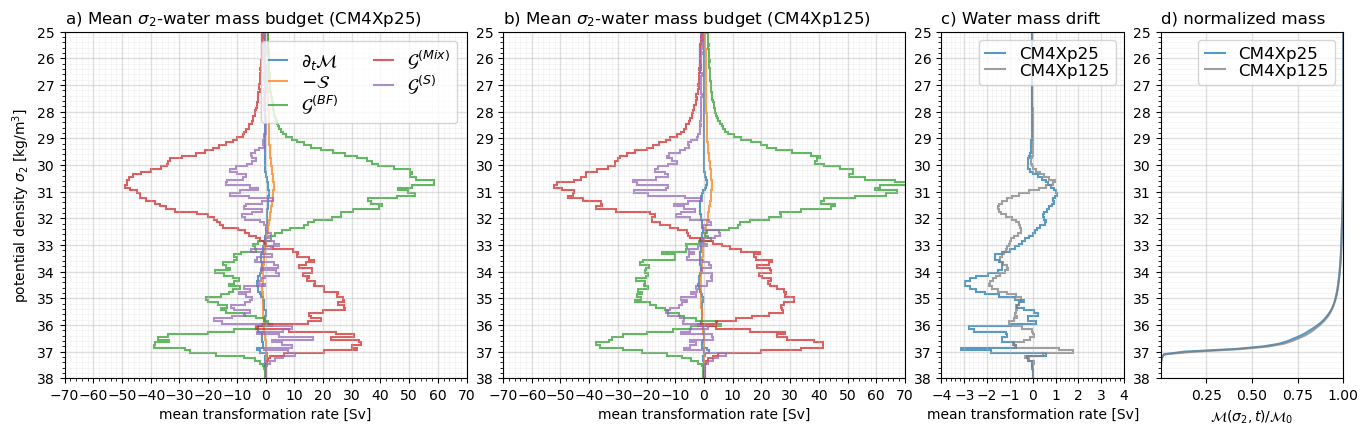

In [22]:
fig = plt.figure(figsize=(16.5, 4.5), layout=None)
gs = fig.add_gridspec(nrows=1, ncols=6)
ax0 = fig.add_subplot(gs[0, 0:2])
ax1 = fig.add_subplot(gs[0, 2:4])
ax2 = fig.add_subplot(gs[0, 4])
ax3 = fig.add_subplot(gs[0, 5])
axes = [ax0, ax1, ax2, ax3]

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

for (ax, model) in zip(axes, ["CM4Xp25", "CM4Xp125"]):
    wmt = xr.open_zarr(f"../../data/wmb_{model}_global_2090-2099.zarr") * toSv
    wmt_mean = wmt.sel(exp="control").mean("time")
    
    kwargs = {"units":"Sv", "alpha":0.75, "lw":1.5}

    stairs(ax, wmt_mean, 'mass_tendency',             label=r"$\partial_{t} \mathcal{M}$",**kwargs)
    stairs(ax,-wmt_mean, 'mass_source',               label=r"$-\mathcal{S}$",            **kwargs)
    stairs(ax, wmt_mean, 'boundary_fluxes',           label=r"$\mathcal{G}^{(BF)}$",      **kwargs)
    stairs(ax, wmt_mean, 'diffusion',                 label=r"$\mathcal{G}^{(Mix)}$",     **kwargs)
    stairs(ax, wmt_mean, 'spurious_numerical_mixing', label=r"$\mathcal{G}^{(S)}$",       **kwargs)

    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.xaxis.set_minor_locator(MultipleLocator(2))
    ax.yaxis.set_major_locator(MultipleLocator(1))
    ax.yaxis.set_minor_locator(MultipleLocator(0.2))
    ax.grid(True, alpha=0.4, linewidth=1, which="major")
    ax.grid(True, alpha=0.15, linewidth=0.5, which="minor")
    if model=="CM4Xp25":
        ax.set_ylabel(r"potential density $\sigma_{2}$ [kg/m$^{3}$]");
        ax.legend(loc="upper right", handlelength=1., labelspacing=0.09, ncols=2, fontsize=13)
        label = "a)"
    else:
        ax.set_ylabel("")
        label = "b)"
    ax.set_title(rf"{label} Mean $\sigma_{{2}}$-water mass budget ({model})", loc="left")
    ax.set_ylim(38, 25)
    ax.set_xlim(-70, 70)

    ax = axes[2]
    if model=="CM4Xp25":
        kwargs["ls"] = "-"
        kwargs["color"] = "C0"
    else:
        kwargs["ls"] = "-"
        kwargs["color"] = "C7"
    stairs(ax, wmt_mean, 'mass_tendency', label=model,**kwargs)
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.xaxis.set_minor_locator(MultipleLocator(0.2))
    ax.yaxis.set_major_locator(MultipleLocator(1))
    ax.yaxis.set_minor_locator(MultipleLocator(0.2))
    ax.grid(True, alpha=0.4, linewidth=1, which="major")
    ax.grid(True, alpha=0.15, linewidth=0.5, which="minor")
    if model=="CM4Xp125":
        ax.legend(loc="upper right", handlelength=1.2, labelspacing=0.08, ncols=1, fontsize=12)

    ax.set_ylabel("")
    ax.set_title(rf"c) Water mass drift", loc="left")
    ax.set_ylim(38, 25)
    ax.set_xlim(-4, 4)
    
    ax = axes[3]
    if model=="CM4Xp25":
        ls = "-"
        color = "C0"
        lw=1.5
    else:
        ls = "-"
        color = "C7"
        lw=1.5
    (rev_cumsum(wmt_mean.layer_mass) / wmt_mean.layer_mass.sum()).plot(ax=ax, y="sigma2_l_target", lw=lw, color=color, alpha=0.75, label=model, ls=ls)
    if model=="CM4Xp125":
        ax.legend(loc="upper right", handlelength=1.2, labelspacing=0.08, ncols=1, fontsize=12)
    ax.set_ylabel("")
    ax.set_ylim(38, 25)
    ax.set_xlim(1e-4, 1)
    ax.yaxis.set_major_locator(MultipleLocator(1))
    ax.yaxis.set_minor_locator(MultipleLocator(0.2))
    ax.grid(True, alpha=0.4, linewidth=1, which="major")
    ax.grid(True, alpha=0.15, linewidth=0.5, which="minor")
    ax.set_title("d) normalized mass", loc="left")
    ax.set_title("")
    ax.set_xlabel(r"$\mathcal{M}(\sigma_{2}, t)/\mathcal{M}_{0}$")

fig.savefig("../../figures/global_wmt_equil.png", dpi=250, bbox_inches="tight")

### Water mass drift timeseries

In [7]:
def preprocess(ds):
    if "time_bounds" in ds:
        ds = ds.drop_dims("time_bounds")
    if "time_original" in ds:
        ds = ds.assign_coords({"time": xr.DataArray(ds.time_original.values, dims=("time",))}).drop_vars("time_original")
    return ds

# CM4Xp25
zarr_list = [
    xr.open_zarr(f"/work/hfd/projects/CM4X/data/wmb_CM4Xp25_global_drift_{year}.zarr/")
    for year in np.arange(1750, 2100, 5)
]
ds_p25 = xr.concat([preprocess(z) for z in zarr_list], dim="time")

# CM4Xp125
zarr_list = [
    xr.open_zarr(f"/work/hfd/projects/CM4X/data/wmb_CM4Xp125_global_drift_{year}.zarr/")
    for year in np.arange(1750, 2100, 5)
]
ds_p125 = xr.concat([preprocess(z) for z in zarr_list], dim="time")

# merge
ds = xr.concat([
    ds_p25.expand_dims({"model":["CM4Xp25"]}),
    ds_p125.expand_dims({"model":["CM4Xp125"]})
], dim="model").isel(exp=slice(None, None, -1))

In [8]:
mass_in_layer = ds.layer_mass.groupby("time.year").mean("time").compute()

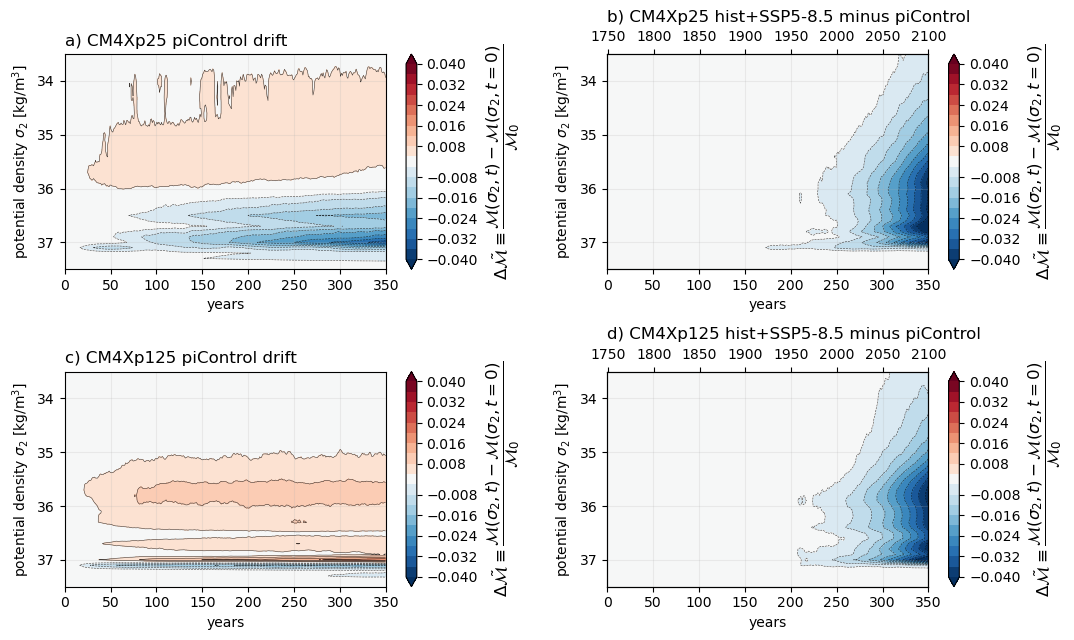

In [50]:
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm

long_labels = {
    "control": "piControl drift",
    "forced": "hist+SSP5-8.5 minus piControl"
}
letter_labels = [["a)", "b)"], ["c)", "d)"]]

def tick_function(x):
    return x+1749

fig, axes = plt.subplots(2,2, figsize=(11,6.5))
for i, model in enumerate(ds.model):
    for j, exp in enumerate(ds.exp):
        ax = axes[i,j]
        plt.sca(ax)
        if exp=="control":
            CDF_drift = (
                (
                    rev_cumsum(mass_in_layer.sel(model=model, exp=exp)) -
                    rev_cumsum(mass_in_layer.sel(model=model, exp=exp).sel(year=1))
                ) /
                mass_in_layer.sel(model=model, exp="control").sel(year=slice(250, None)).mean("year").sum()
            ).transpose()
        else:
            CDF_drift = (
                (
                    rev_cumsum(mass_in_layer.sel(model=model, exp="forced" )) -
                    rev_cumsum(mass_in_layer.sel(model=model, exp="control"))
                ) /
                mass_in_layer.sel(model=model, exp="control").sel(year=slice(250, None)).mean("year").sum()
            ).transpose()

        vmax = 4e-2
        dlev = 0.4e-2
        levels = np.concatenate((np.arange(-vmax, 0, dlev), np.arange(dlev, vmax+dlev, dlev)))
        label_levels = np.concatenate((np.arange(-vmax, 0, 2*dlev), np.arange(2*dlev, vmax+dlev, 2*dlev)))
        cf = ax.contourf(
            np.arange(0.5, 350, 1),
            ds.sigma2_l_target.values,
            CDF_drift,
            cmap="RdBu_r",
            levels=levels,
            vmin=-vmax, vmax=vmax,
            extend="both",
            linestyles="-"
        )
        cb = plt.colorbar(
            cf,
            ticks=label_levels,
        )
        cb.set_label(
            label=r"$\Delta \tilde{\mathcal{M}} \equiv \dfrac{\mathcal{M}(\sigma_{2}, t) - \mathcal{M}(\sigma_{2}, t=0)}{\mathcal{M}_{0}}$",
            size=12
        )
        ax.contour(
            np.arange(0.5, 350, 1),
            ds.sigma2_l_target.values,
            CDF_drift,
            colors="k",
            levels=levels,
            linewidths=0.4,
            alpha=0.75
        )
        
        ax.set_xlim(0, 350)
        ax.set_ylim(37.5, 33.5)
        ax.set_title(f"{letter_labels[i][j]} {str(model.values)} {long_labels[str(exp.values)]}", loc="left")

        ax.grid(True, alpha=0.2)
        ax.set_xlabel("years")
        ax.set_ylabel(r"potential density $\sigma_{2}$ [kg/m$^{3}$]")

        if exp == "forced":
            ax2 = ax.twiny()
            xticks = ax.get_xticks()
            ax2.set_xticks(xticks + 1)
            ax2.set_xticklabels([str(int(e)) for e in tick_function(xticks + 1)])
        ax.set_xlim(0, 350)

plt.tight_layout()
plt.savefig("../../figures/global_wmt_drift", dpi=250, bbox_inches="tight")